Run this notebook in cmts_learn_olci environment from EUMETlab
Downloading data from MODIS
Colection1: MODISA_L2_OC_NRT
Colection2: MODISA_L2_OC

In [2]:
from IPython.display import JSON
import cartopy
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean #nice colors scheme for ploting
import netCDF4 as nc

# To have plot on notebook run once command %matplotlib inline
%matplotlib inline

Login to earth access
Earthdata Login: 1234ulus, mail from Kiel

In [3]:
auth = earthaccess.login(persist=True)

Temporal argument: current Arctic vegetation season 
Spatial argument: west coast of Island
cloud_cover parameter: max 50% of cloud coverage

In [4]:
tspan = ("2024-03-01", "2024-08-10")
bbox = (-15, 64, -12, 65)
cc = (0, 50)

In [5]:
results = earthaccess.search_data(
    short_name = "MODISA_L2_OC",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=cc,
) + earthaccess.search_data(
    short_name = "MODISA_L2_OC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=cc,
)
print(len(results))
print(results[0:5])

245
[Collection: {'ShortName': 'MODISA_L2_OC', 'Version': 'R2022.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 67.18592, 'Longitude': -43.8807}, {'Latitude': 60.40119, 'Longitude': 2.19665}, {'Latitude': 70.61304, 'Longitude': 39.48347}, {'Latitude': 84.5455, 'Longitude': -59.67136}, {'Latitude': 67.18592, 'Longitude': -43.8807}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-03-11T04:25:01Z', 'EndingDateTime': '2024-03-11T04:29:59Z'}}
Size(MB): 11.883947372436523
Data: ['https://oceandata.sci.gsfc.nasa.gov/cmr/getfile/AQUA_MODIS.20240311T042501.L2.OC.nc'], Collection: {'Version': 'R2022.0', 'ShortName': 'MODISA_L2_OC'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 68.56538, 'Longitude': -50.3321}, {'Latitude': 61.47038, 'Longitude': -2.19514}, {'Latitude': 70.9315, 'Longitude': 37.36622}, {'Latitude': 85.77259, 'Longitude': -73

Because we filter with cloud cover, many scenes are without signal: scene made in night.
To get rid of nonsignal files, filter the results by file size (file schould be bigger then 30 MB for MODIS).
We create list with links to files, in case we want to download them manually

In [6]:
data_links = []
for i in results:
    if i.size() > 30:
        data_links.append ({"links": i.data_links(), "size (MB):": i.size()})
        JSON(data_links, expanded=True)
data_links

[{'links': ['https://oceandata.sci.gsfc.nasa.gov/cmr/getfile/AQUA_MODIS.20240516T114501.L2.OC.NRT.nc'],
  'size (MB):': 42.63924598693848},
 {'links': ['https://oceandata.sci.gsfc.nasa.gov/cmr/getfile/AQUA_MODIS.20240517T122501.L2.OC.NRT.nc'],
  'size (MB):': 44.13312816619873},
 {'links': ['https://oceandata.sci.gsfc.nasa.gov/cmr/getfile/AQUA_MODIS.20240526T120001.L2.OC.NRT.nc'],
  'size (MB):': 42.24368667602539},
 {'links': ['https://oceandata.sci.gsfc.nasa.gov/cmr/getfile/AQUA_MODIS.20240613T031001.L2.OC.NRT.nc'],
  'size (MB):': 33.66801834106445}]

We create list with filtered granules to batch download

In [7]:
fresults = []
for i in results:
    if i.size() > 30:
        fresults.append(i)

len(fresults)

4

We download filtered results to folder "data island" at your local directory (.)

In [8]:
paths = earthaccess.download(fresults, "data_island")
paths

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

['data_island\\AQUA_MODIS.20240516T114501.L2.OC.NRT.nc',
 'data_island\\AQUA_MODIS.20240517T122501.L2.OC.NRT.nc',
 'data_island\\AQUA_MODIS.20240526T120001.L2.OC.NRT.nc',
 'data_island\\AQUA_MODIS.20240613T031001.L2.OC.NRT.nc']

To see groups in dataset it is good to use netCDF4 not xarray (non hierarchical). Groups: sensor_band_parameters, scan_line_attributes, geophysical_data, navigation_data, processing_control

In [9]:
prod = nc.Dataset(paths[0]) #open the first downloaded file by netCDF4.
prod

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: MODISA Level-2 Data
    product_name: AQUA_MODIS.20240516T114501.L2.OC.NRT.nc
    processing_version: R2022.0
    equatorCrossingLongitude: -123.03457
    orbit_number: 117252
    history: l2gen par=/data1/sdpsoper/vdc/vpu0/workbuf/A2024137114500.L1B_LAC.param metafile=AQUA_MODIS.20240516T114501.L2.OC.NRT.nc.meta
    instrument: MODIS
    platform: Aqua
    Conventions: CF-1.6 ACDD-1.3
    license: https://science.nasa.gov/earth-science/earth-science-data/data-information-policy/
    naming_authority: gov.nasa.gsfc.sci.oceandata
    id: R2022.0/L2/AQUA_MODIS.20240516T114501.L2.OC.NRT.nc
    date_created: 2024-05-16T13:02:46.000Z
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    keywords: Earth Science > Oceans > Ocean Optics > Ocean Color
    standard_name_vocabulary: CF Standard Name Table v36
    institution: NASA Goddard Space Flight Center, Ocean E

In [10]:
cont = nc.Dataset(paths[0], group="processing_control") #in processing_control there are some mask but I don't know how to use them yet
cont

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: MODISA Level-2 Data
    product_name: AQUA_MODIS.20240516T114501.L2.OC.NRT.nc
    processing_version: R2022.0
    equatorCrossingLongitude: -123.03457
    orbit_number: 117252
    history: l2gen par=/data1/sdpsoper/vdc/vpu0/workbuf/A2024137114500.L1B_LAC.param metafile=AQUA_MODIS.20240516T114501.L2.OC.NRT.nc.meta
    instrument: MODIS
    platform: Aqua
    Conventions: CF-1.6 ACDD-1.3
    license: https://science.nasa.gov/earth-science/earth-science-data/data-information-policy/
    naming_authority: gov.nasa.gsfc.sci.oceandata
    id: R2022.0/L2/AQUA_MODIS.20240516T114501.L2.OC.NRT.nc
    date_created: 2024-05-16T13:02:46.000Z
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    keywords: Earth Science > Oceans > Ocean Optics > Ocean Color
    standard_name_vocabulary: CF Standard Name Table v36
    institution: NASA Goddard Space Flight Center, Ocean E

After quick exploration, time to open datasets with xarray.
Prepared 4 datasets:
1) prod to have attributes like name of file, date etc.
2) obs to have variables: obs, chlorophil etc.
3) nav to have longitude and latitude
4) cont because I hope one day I will use masks

In [11]:
prod = xr.open_dataset(paths[0]) #open the first downloaded file
obs = xr.open_dataset(paths[0], group="geophysical_data") #open set with biochemical data
nav = xr.open_dataset(paths[0], group="navigation_data") #open set with cordinates
cont = xr.open_dataset(paths[0], group="processing_control") #open set with processing_control

To explore the attributes of product use:

In [12]:
prod.attrs

{'title': 'MODISA Level-2 Data',
 'product_name': 'AQUA_MODIS.20240516T114501.L2.OC.NRT.nc',
 'processing_version': 'R2022.0',
 'equatorCrossingLongitude': -123.03457,
 'orbit_number': 117252,
 'history': 'l2gen par=/data1/sdpsoper/vdc/vpu0/workbuf/A2024137114500.L1B_LAC.param metafile=AQUA_MODIS.20240516T114501.L2.OC.NRT.nc.meta',
 'instrument': 'MODIS',
 'platform': 'Aqua',
 'Conventions': 'CF-1.6 ACDD-1.3',
 'license': 'https://science.nasa.gov/earth-science/earth-science-data/data-information-policy/',
 'naming_authority': 'gov.nasa.gsfc.sci.oceandata',
 'id': 'R2022.0/L2/AQUA_MODIS.20240516T114501.L2.OC.NRT.nc',
 'date_created': '2024-05-16T13:02:46.000Z',
 'keywords_vocabulary': 'NASA Global Change Master Directory (GCMD) Science Keywords',
 'keywords': 'Earth Science > Oceans > Ocean Optics > Ocean Color',
 'standard_name_vocabulary': 'CF Standard Name Table v36',
 'institution': 'NASA Goddard Space Flight Center, Ocean Ecology Laboratory, Ocean Biology Processing Group',
 'crea

To explore the variables in biochemical data:

In [13]:
obs.data_vars

Data variables:
    aot_869   (number_of_lines, pixels_per_line) float32 11MB ...
    angstrom  (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_412   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_443   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_469   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_488   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_531   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_547   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_555   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_645   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_667   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_678   (number_of_lines, pixels_per_line) float32 11MB ...
    chlor_a   (number_of_lines, pixels_per_line) float32 11MB ...
    Kd_490    (number_of_lines, pixels_per_line) float32 11MB ...
    pic       (number_of_lines, pixels_per_line) float32 11M

Make first plot: RRS of one band.

Text(0.5, 1.0, 'AQUA_MODIS.20240516T114501.L2.OC.NRT.nc')

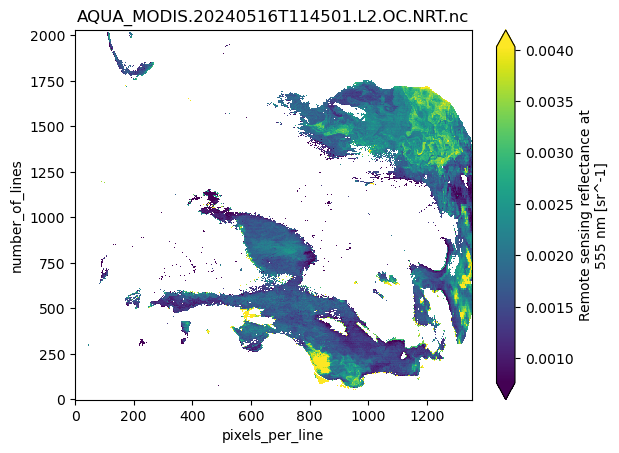

In [14]:
fig, ax = plt.subplots(dpi=100)
src = obs.Rrs_555
src.plot.imshow(robust=True, ax=ax)
plt.title(prod.attrs["product_name"]) #for title refere to product attributes, because biochemical data do not have this 

To explore the variables in coordinates

In [15]:
nav.data_vars

Data variables:
    longitude     (number_of_lines, pixel_control_points) float32 11MB ...
    latitude      (number_of_lines, pixel_control_points) float32 11MB ...
    cntl_pt_cols  (pixel_control_points) float64 11kB ...
    cntl_pt_rows  (number_of_lines) float64 16kB ...
    tilt          (number_of_lines) float32 8kB ...

To make a proper coordinates: set coord and change name from pixel_control_points to pixels_per_line

In [16]:
#from navigation variables we choose lon and lat as the coords
nav = nav.set_coords(("longitude", "latitude"))
#in MODIS for long and lat second variable name is "pixel_control_points" so we change it to"pixels_per_line" 
nav = nav.rename({"pixel_control_points": "pixels_per_line"})
nav

<xarray.Dataset> Size: 22MB
Dimensions:       (number_of_lines: 2030, pixels_per_line: 1354)
Coordinates:
    longitude     (number_of_lines, pixels_per_line) float32 11MB ...
    latitude      (number_of_lines, pixels_per_line) float32 11MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    cntl_pt_cols  (pixels_per_line) float64 11kB ...
    cntl_pt_rows  (number_of_lines) float64 16kB ...
    tilt          (number_of_lines) float32 8kB ...
Attributes:
    gringpointlongitude:  [ 42.176407   8.011188 -13.894216  43.53105 ]
    gringpointlatitude:   [55.760296 50.79128  65.1276   73.590126]
    gringpointsequence:   [1 2 3 4]

Now merge to one dataset data from: 
prod (title, data in attributes)
obs (rrs etc), 
nav.cords (longitude, latitude)

In [17]:
dataset = xr.merge((prod, obs, nav.coords))
dataset

<xarray.Dataset> Size: 242MB
Dimensions:    (number_of_lines: 2030, pixels_per_line: 1354)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 11MB ...
    latitude   (number_of_lines, pixels_per_line) float32 11MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables: (12/20)
    aot_869    (number_of_lines, pixels_per_line) float32 11MB ...
    angstrom   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_412    (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_443    (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_469    (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_488    (number_of_lines, pixels_per_line) float32 11MB ...
    ...         ...
    pic        (number_of_lines, pixels_per_line) float32 11MB ...
    poc        (number_of_lines, pixels_per_line) float32 11MB ...
    ipar       (number_of_lines, pixels_per_line) float32 11MB ...
    nflh       (number_of_lines, pixels_per_line) float32 11MB ...
    par        (number_of_lines, pixels_per_line) float32 11MB ...
    l2_flags   (number_of_lines, pixels_per_line) int32 11MB ...
Attributes: (12/50)
    title:                             MODISA Level-2 Data
    product_name:                      AQUA_MODIS.20240516T114501.L2.OC.NRT.nc
    processing_version:                R2022.0
    equatorCrossingLongitude:          -123.03457
    orbit_number:                      117252
    history:                           l2gen par=/data1/sdpsoper/vdc/vpu0/wor...
    ...                                ...
    geospatial_lon_max:                43.53105
    geospatial_lon_min:                -13.898983
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9779829978942871

To see if data were merged properly

Text(0.5, 1.0, 'AQUA_MODIS.20240516T114501.L2.OC.NRT.nc')

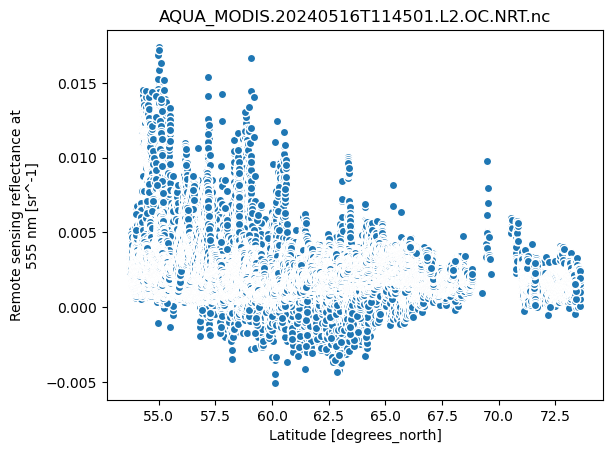

In [18]:
rrs = dataset["Rrs_555"]
plot = rrs.plot.scatter(x="latitude")
plt.title(dataset.attrs["product_name"])

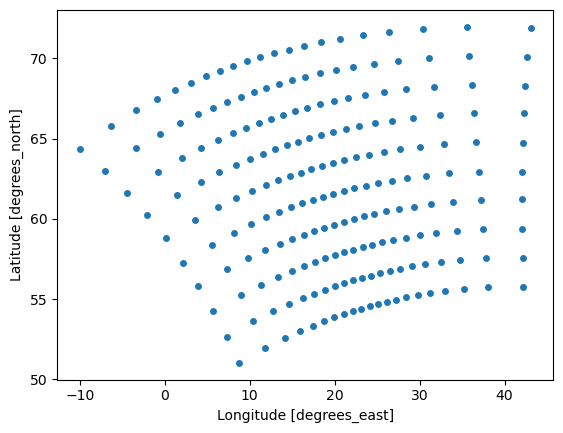

In [19]:
plot = dataset.sel(
    {
        "number_of_lines": slice(None, None, 2030 // 10),#chceck first value on data set, second can be adjust
        "pixels_per_line": slice(None, None, 1354 // 20),#chceck first value on data set, second can be adjust
    },
).plot.scatter(x="longitude", y="latitude")

It is a problem for matplot to make a graph with NaN values in x an y. To cut off problematic values we create array with filtered data for latitude and longitude

In [20]:
array = dataset["Rrs_555"].where(
    (
        (dataset["latitude"] > 55)
        & (dataset["latitude"] < 70)
        & (dataset["longitude"] > -10)
        & (dataset["longitude"] < 40)
    ),
    drop=True,
)
array

<xarray.DataArray 'Rrs_555' (number_of_lines: 2020, pixels_per_line: 1331)> Size: 11MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 11MB 40.55 ... -13.89
    latitude   (number_of_lines, pixels_per_line) float32 11MB 55.76 ... 65.13
Dimensions without coordinates: number_of_lines, pixels_per_line
Attributes:
    long_name:         Remote sensing reflectance at 555 nm
    units:             sr^-1
    standard_name:     surface_ratio_of_upwelling_radiance_emerging_from_sea_...
    valid_min:         -30000
    valid_max:         25000
    solar_irradiance:  1837.5674

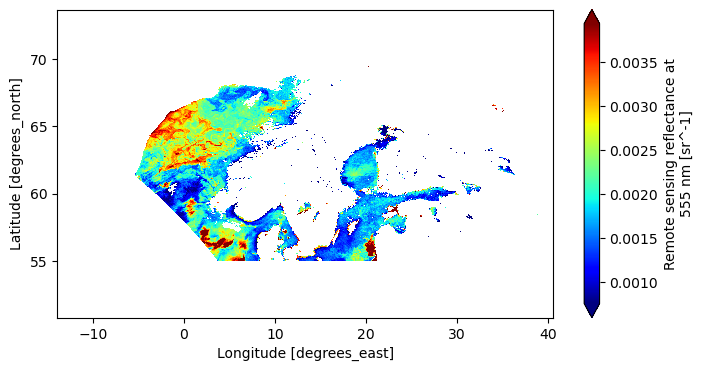

In [21]:
plot = array.plot(
    x="longitude", y="latitude", aspect=2, size=4, cmap="jet", robust=True
)

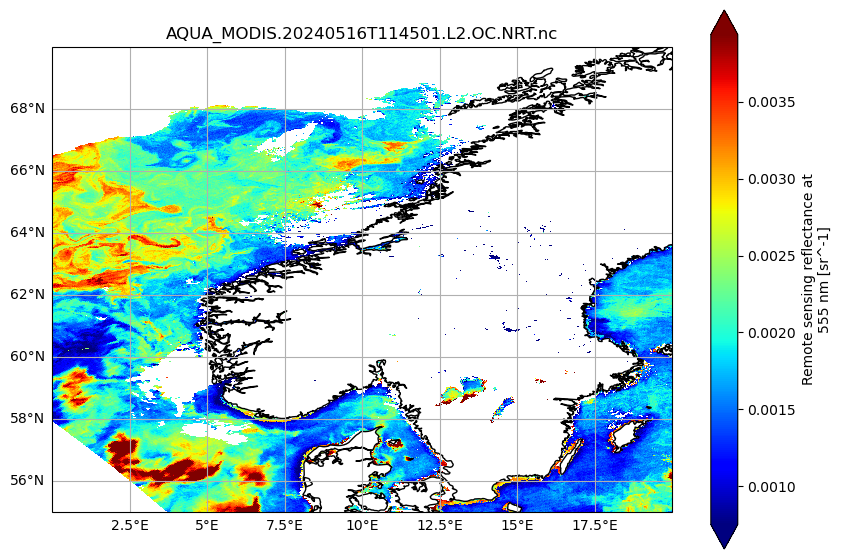

In [22]:
fig = plt.figure(figsize=(10, 7)) # create a figure and define its size
ax = plt.axes(projection=cartopy.crs.PlateCarree()) # create the axes of the plot in projection
ax.coastlines()
array.plot(x="longitude", y="latitude", cmap="jet", robust=True, ax=ax)  # define the extent of the map [lon_min,lon_max,lat_min,lat_max]
ax.set_extent([0, 20, 55 , 70],crs=cartopy.crs.PlateCarree())   # define the extent of the map [lon_min,lon_max,lat_min,lat_max]
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}) # add the grid lines
ax.set_title(dataset.attrs["product_name"], loc="center") # add the figure title as file name
plt.show()

Make a loop to see each downloaded file. Unfortunately there is no Island west coast. Maps are scattering on the edges

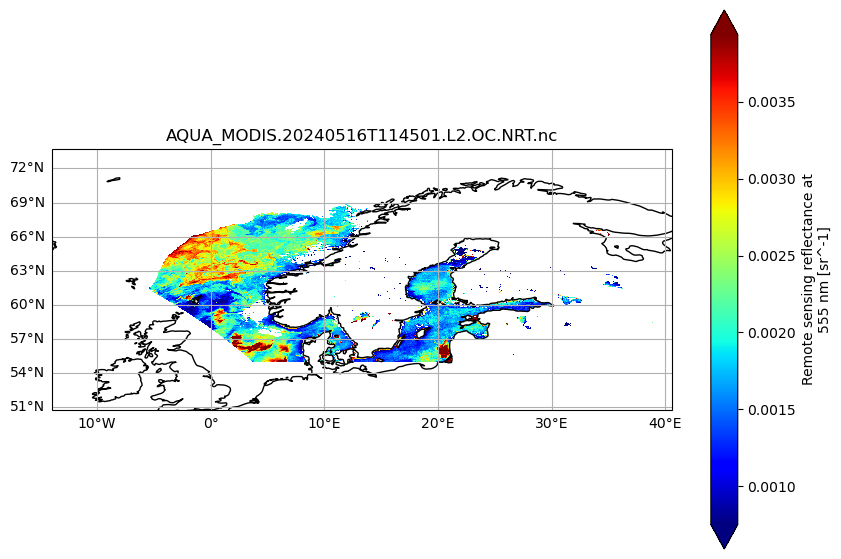

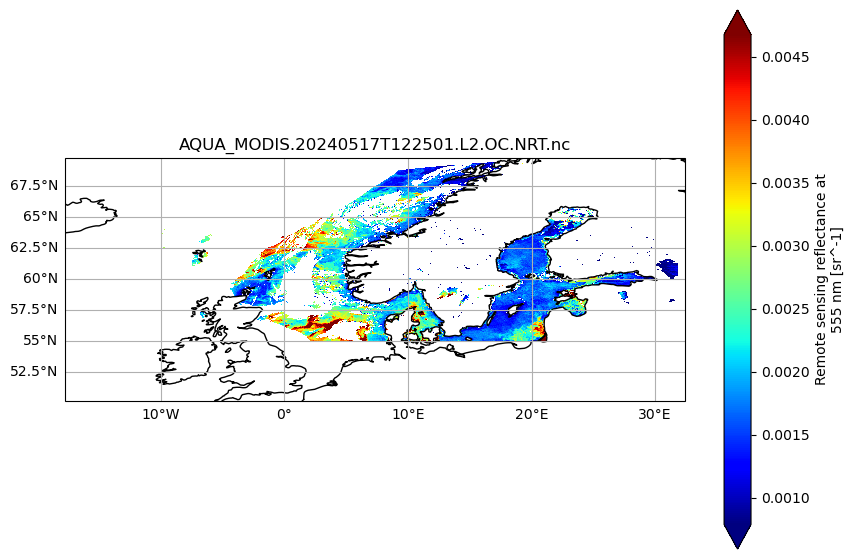

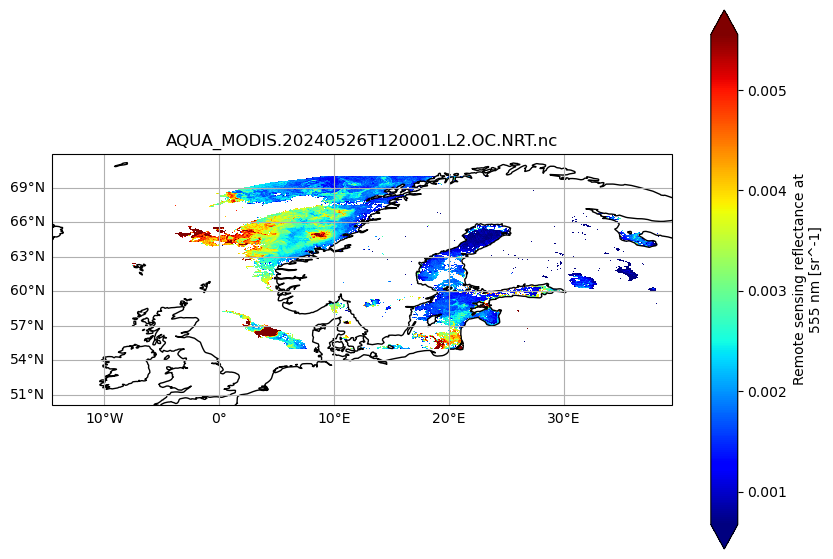

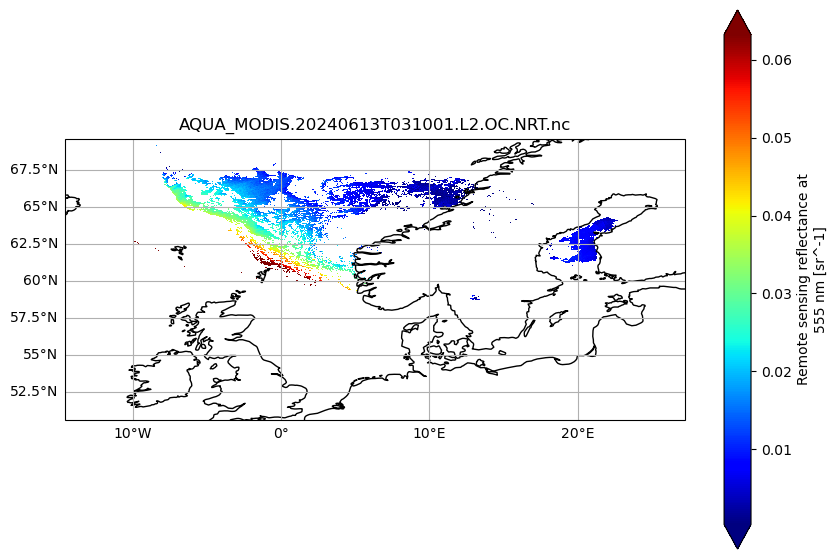

In [23]:
for path in paths:
    prod = xr.open_dataset(path)
    obs = xr.open_dataset(path, group="geophysical_data")
    nav = xr.open_dataset(path, group="navigation_data")

    nav = nav.set_coords(("longitude", "latitude"))
    nav = nav.rename({"pixel_control_points": "pixels_per_line"})

    dataset = xr.merge((prod, obs, nav.coords))

    array = dataset["Rrs_555"].where(
        (
            (dataset["latitude"] > 55)
            & (dataset["latitude"] < 70)
            & (dataset["longitude"] > -10)
            & (dataset["longitude"] < 40)
        ),
        drop=True,
    )
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=cartopy.crs.PlateCarree())
    ax.coastlines()
    array.plot(x="longitude", y="latitude", cmap="jet", robust=True, ax=ax)
    ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
    ax.set_title(dataset.attrs["product_name"], loc="center")
    plt.show()